<a href="https://colab.research.google.com/github/Jair-RM/Modelacion-Financiera/blob/main/OC_SMF_Acciones%20Mi%20Version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Manejo de Acciones

**Oliver Cuate**

*28 de febrero de 2025*

---

En este cuaderno le mostraré cómo usar [Pymoo](https://pymoo.org/) para resolver el problema clásico de portafolios (2 acciones).

## Obtener precios de acciones

In [31]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

hoy = pd.Timestamp.today()
inicio = hoy - pd.Timedelta(days=365*5)

print(inicio, hoy)

#tickers = ["^MXX", "BIMBOA.MX"]     # IPC MEXICO, BIMBO
tickers = ["KOF", "DELL"]     # Coca-Cola FEMSA, Dell Technologies Inc.

# inicio.strftime('%Y-%m-%d') # por si hay error
#datos = yf.download(ticker, start=inicio, end=hoy).copy() # todos los datos

datos = yf.download(tickers, start=inicio, end=hoy)['Close'].copy() # todos los datos

[*********************100%***********************]  2 of 2 completed

2020-03-01 18:37:20.888149 2025-02-28 18:37:20.888149


Vemos los datos

In [32]:
datos

Ticker,DELL,KOF
Date,,
2020-03-02,19.974047,45.343887
2020-03-03,19.686619,44.772972
2020-03-04,20.440529,45.408218
2020-03-05,19.248404,44.218132
2020-03-06,18.668835,43.405979
...,...,...
2025-02-24,114.139999,88.339996
2025-02-25,110.650002,87.730003
2025-02-26,115.650002,86.589996


## Calculamos los rendimientos

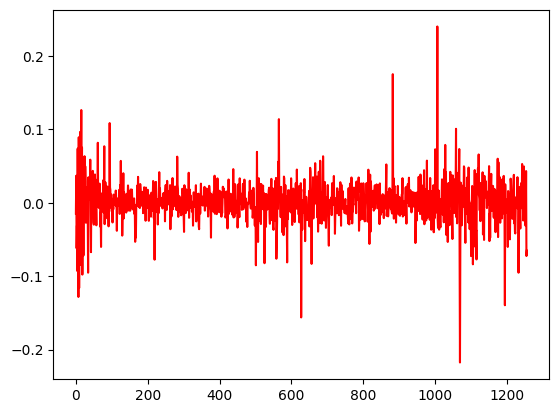

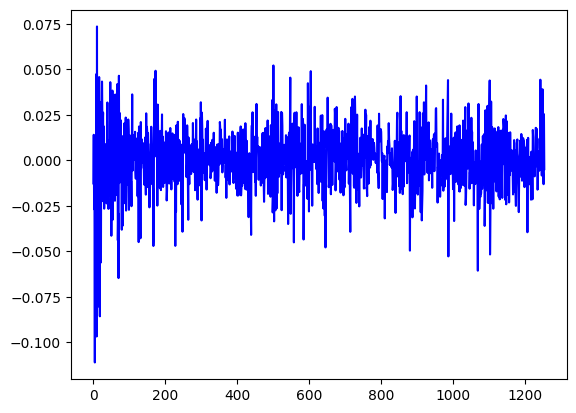

In [33]:
rend = (datos.values[1:]-datos.values[0:-1])/datos.values[1:]

plt.plot(range(rend.shape[0]),rend[:,0],'r')
plt.show()

plt.plot(range(rend.shape[0]),rend[:,1],'b')
plt.show()

In [34]:
r = rend.mean(axis=0)
r

array([0.00090675, 0.00038424])

In [35]:
Cov = np.cov(rend, rowvar=False)
Cov

array([[0.00076567, 0.00012937],
       [0.00012937, 0.0002965 ]])

## Uso de Pymoo

Primero, hay que instalar Pymoo

In [36]:
!pip install -U pymoo

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |       50 |      7 |  0.000000E+00 |  0.2551687336 |             - |             -
     2 |      100 |     15 |  0.000000E+00 |  0.0366190309 |  0.0302876160 |         ideal
     3 |      150 |     25 |  0.000000E+00 |  0.000000E+00 |  0.0871517200 |         ideal
     4 |      200 |     33 |  0.000000E+00 |  0.000000E+00 |  0.0613927949 |         ideal
     5 |      250 |     43 |  0.000000E+00 |  0.000000E+00 |  0.0049538976 |             f
     6 |      300 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0054842822 |             f
     7 |      350 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0053777762 |         ideal
     8 |      400 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0034348486 |             f
     9 |      450 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0033511339 |         ideal
    10 |      500 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0023709972 |             f

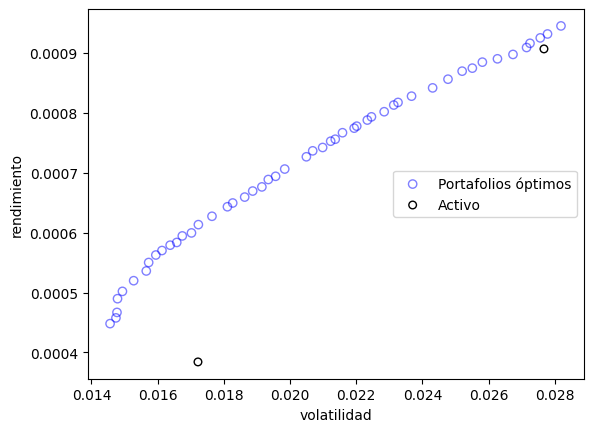

In [37]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.problem import Problem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

class Portafolio(Problem):   # nombre que le queremos dar (Nombre de lo que es)
  def __init__(self, mu, cov):
    self.mu = mu
    self.cov = cov
    super().__init__(n_var=2, n_obj=2, n_ieq_constr=1, xl=0.0, xu=1.0)
                    # tenemos 2 activos
                    #          2 objetivos, minimizatr y maximizar
                    #                  restriccion es que la suma de pesos sea igual a 1
                    #                                   los pesos estan entre 0 y 1

  def _evaluate(self, x, out, *args, **kwargs):
    rendimiento = x @ self.mu
    riesgo = np.zeros(x.shape[0])
    for (i,w) in enumerate(x):
      riesgo[i] = np.sqrt(w @ self.cov @ w.T)

    out["F"] = [riesgo, -rendimiento]
    out["G"] = np.abs( np.sum(x, axis=1) - 1.0 ) - 0.1

problem = Portafolio(r,Cov)

algorithm = NSGA2(pop_size=50)   # poblacion de 50

res = minimize(problem,
               algorithm,
               ('n_gen', 200),
               seed=1,
               verbose=True)


X, F = res.opt.get("X", "F")
F = F * [1, -1]

plt.scatter(F[:, 0], F[:, 1], facecolor="none", edgecolors="blue", alpha=0.5, label="Portafolios óptimos")
plt.scatter(Cov.diagonal() ** 0.5, r, facecolor="none", edgecolors="black", s=30, label="Activo")
#plt.legend(loc='best')
plt.legend(loc=7)
plt.xlabel("volatilidad")
plt.ylabel("rendimiento")
plt.show()

In [38]:
np.sum( res.X, axis=1 )

array([0.90009912, 1.09997595, 1.06825622, 1.08680413, 1.08064035,
       1.04748171, 1.06406132, 1.09242959, 0.93396128, 0.91607565,
       0.90128734, 0.96179586, 1.09137155, 1.02369324, 0.9962801 ,
       0.97637832, 0.90357684, 0.90429758, 1.09310305, 0.91117707,
       1.0879255 , 1.08696022, 1.04512076, 0.90976385, 0.92413346,
       1.07303391, 1.0786819 , 0.92239089, 1.05474515, 0.94658063,
       1.07300131, 1.06643912, 1.08972525, 0.9707543 , 1.06777081,
       1.05781518, 1.04724472, 0.91068721, 1.0883156 , 0.92511032,
       1.07964231, 1.01845607, 1.03355578, 1.08249796, 0.99787991,
       1.05447591, 1.08485413, 0.91157076, 1.06839977, 1.04537437])

[Posición de la etiqueta](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html)